In [ ]:
import nltk
from nltk.corpus import inaugural

nltk.download("inaugural")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

In [2]:
for idx, file_id in enumerate(inaugural.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	1789-Washington.txt
#2	1793-Washington.txt
#3	1797-Adams.txt
#4	1801-Jefferson.txt
#5	1805-Jefferson.txt
#6	1809-Madison.txt
#7	1813-Madison.txt
#8	1817-Monroe.txt
#9	1821-Monroe.txt
#10	1825-Adams.txt
#11	1829-Jackson.txt
#12	1833-Jackson.txt
#13	1837-VanBuren.txt
#14	1841-Harrison.txt
#15	1845-Polk.txt
#16	1849-Taylor.txt
#17	1853-Pierce.txt
#18	1857-Buchanan.txt
#19	1861-Lincoln.txt
#20	1865-Lincoln.txt
#21	1869-Grant.txt
#22	1873-Grant.txt
#23	1877-Hayes.txt
#24	1881-Garfield.txt
#25	1885-Cleveland.txt
#26	1889-Harrison.txt
#27	1893-Cleveland.txt
#28	1897-McKinley.txt
#29	1901-McKinley.txt
#30	1905-Roosevelt.txt
#31	1909-Taft.txt
#32	1913-Wilson.txt
#33	1917-Wilson.txt
#34	1921-Harding.txt
#35	1925-Coolidge.txt
#36	1929-Hoover.txt
#37	1933-Roosevelt.txt
#38	1937-Roosevelt.txt
#39	1941-Roosevelt.txt
#40	1945-Roosevelt.txt
#41	1949-Truman.txt
#42	1953-Eisenhower.txt
#43	1957-Eisenhower.txt
#44	1961-Kennedy.txt
#45	1965-Johnson.txt
#46	1969-Nixon.txt
#47	1973-Nixon.txt
#48	1977-Car

In [28]:
presidents = set([file_id[5:-4] for file_id in inaugural.fileids()])
president_data_dict = {}

for index, president in enumerate(presidents):
    speeches = [
        inaugural.sents(file_id)
        for file_id in inaugural.fileids()
        if president in file_id
    ]
    sent_num = len([sent for speech in speeches for sent in speech])
    president_data_dict[president] = sent_num

sentences_num_by_president_name: dict[str, int] = dict(
    sorted(president_data_dict.items(), key=lambda pd: pd[1], reverse=True)
)

for idx, president_item in enumerate(sentences_num_by_president_name.items()):
    print(f"{idx + 1}:\t{president_item[0]} - {president_item[1]} sentences")

1:	Harrison - 367 sentences
2:	Bush - 337 sentences
3:	Roosevelt - 308 sentences
4:	Reagan - 253 sentences
5:	Monroe - 251 sentences
6:	McKinley - 230 sentences
7:	Eisenhower - 215 sentences
8:	Obama - 204 sentences
9:	Coolidge - 197 sentences
10:	Clinton - 193 sentences
11:	Nixon - 175 sentences
12:	Biden - 170 sentences
13:	Lincoln - 165 sentences
14:	Taft - 159 sentences
15:	Hoover - 158 sentences
16:	Polk - 153 sentences
17:	Harding - 149 sentences
18:	Wilson - 128 sentences
19:	Truman - 116 sentences
20:	Garfield - 112 sentences
21:	Adams - 111 sentences
22:	Pierce - 104 sentences
23:	Cleveland - 102 sentences
24:	VanBuren - 95 sentences
25:	Johnson - 94 sentences
26:	Trump - 90 sentences
27:	Buchanan - 89 sentences
28:	Jefferson - 87 sentences
29:	Grant - 85 sentences
30:	Hayes - 59 sentences
31:	Jackson - 55 sentences
32:	Madison - 54 sentences
33:	Carter - 53 sentences
34:	Kennedy - 52 sentences
35:	Washington - 28 sentences
36:	Taylor - 22 sentences


In [4]:
PRESIDENT_A = "Bush"
PRESIDENT_B = "Harrison"

In [5]:
speeches_a = [
    inaugural.sents(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_A in file_id
]

sents_a = [sent for speech in speeches_a for sent in speech]
for sentence in sents_a[:50]:
    print(" ".join(sentence))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(sents_a)} sentences")

Mr . Chief Justice , Mr . President , Vice President Quayle , Senator Mitchell , Speaker Wright , Senator Dole , Congressman Michael , and fellow citizens , neighbors , and friends :
There is a man here who has earned a lasting place in our hearts and in our history .
President Reagan , on behalf of our Nation , I thank you for the wonderful things that you have done for America .
I have just repeated word for word the oath taken by George Washington 200 years ago , and the Bible on which I placed my hand is the Bible on which he placed his .
It is right that the memory of Washington be with us today , not only because this is our Bicentennial Inauguration , but because Washington remains the Father of our Country .
And he would , I think , be gladdened by this day ; for today is the concrete expression of a stunning fact : our continuity these 200 years since our government began .
We meet on democracy ' s front porch , a good place to talk as neighbors and as friends .
For this is a 

In [6]:
speeches_b = [
    inaugural.sents(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_B in file_id
]

sents_b = [sent for speech in speeches_b for sent in speech]
for sentence in sents_b[:50]:
    print(" ".join(sentence))
print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(sents_b)} sentences")

Called from a retirement which I had supposed was to continue for the residue of my life to fill the chief executive office of this great and free nation , I appear before you , fellow - citizens , to take the oaths which the Constitution prescribes as a necessary qualification for the performance of its duties ; and in obedience to a custom coeval with our Government and what I believe to be your expectations I proceed to present to you a summary of the principles which will govern me in the discharge of the duties which I shall be called upon to perform .
It was the remark of a Roman consul in an early period of that celebrated Republic that a most striking contrast was observable in the conduct of candidates for offices of power and trust before and after obtaining them , they seldom carrying out in the latter case the pledges and promises made in the former .
However much the world may have improved in many respects in the lapse of upward of two thousand years since the remark was 

In [7]:
from authorship_tool.feature_util import frequency_calculator as fc

existing_tags: set[str] = set()

for sentence in sents_a + sents_b:
    existing_tags.update(fc.all_pos_frequency(sentence).keys())

print(existing_tags)

{'VBP', 'TO', 'NN', 'NNS', 'RP', 'POS', 'DT', 'VBN', 'UH', 'WDT', 'RBR', 'RBS', '(', 'IN', 'RB', 'VB', 'NNPS', 'NNP', '.', 'EX', 'WP', 'VBG', 'PRP$', 'PRP', 'WRB', 'JJ', 'PDT', 'VBZ', ',', 'CC', 'JJR', 'VBD', 'CD', ')', "''", ':', 'JJS', 'WP$', 'MD'}


In [8]:
from authorship_tool.feature_util.dataset_generator import DatasetGenerator
import pandas as pd
import numpy as np

dg = DatasetGenerator(existing_tags)
data = []
correctness = []

for sentence in sents_a:
    x, y = dg.generate_dataset_sent(sentence, existing_tags, True)
    data.append(x)
    correctness.append(y)

for sentence in sents_b:
    x, y = dg.generate_dataset_sent(sentence, existing_tags, False)
    data.append(x)
    correctness.append(y)

In [9]:
df = pd.DataFrame(data, columns=dg.columns)
nd_correctness = np.array(correctness)

display(df.head(10))

,word variation,uncommon word frequency,sentence length,average word length,VBP,TO,NN,NNS,RP,POS,...,CC,JJR,VBD,CD,),'',:,JJS,WP$,MD
0,0.617647,0.941176,34,4.382353,0.000000,0.000,0.000000,0.029412,0.0,0.0,...,0.058824,0.0,0.000000,0.000000,0.0,0.00,0.029412,0.0,0.0,0.000000
1,0.842105,0.421053,19,3.526316,0.000000,0.000,0.052632,0.052632,0.0,0.0,...,0.052632,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
2,0.869565,0.565217,23,4.000000,0.043478,0.000,0.043478,0.043478,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
3,0.771429,0.542857,35,3.714286,0.028571,0.000,0.028571,0.028571,0.0,0.0,...,0.028571,0.0,0.057143,0.028571,0.0,0.00,0.000000,0.0,0.0,0.000000
4,0.781250,0.468750,32,4.531250,0.000000,0.000,0.031250,0.000000,0.0,0.0,...,0.031250,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
5,0.941176,0.647059,34,4.000000,0.029412,0.000,0.029412,0.029412,0.0,0.0,...,0.029412,0.0,0.029412,0.029412,0.0,0.00,0.029412,0.0,0.0,0.029412
6,0.950000,0.650000,20,3.500000,0.050000,0.050,0.050000,0.050000,0.0,0.0,...,0.050000,0.0,0.000000,0.000000,0.0,0.05,0.000000,0.0,0.0,0.000000
7,0.739130,0.521739,23,3.521739,0.043478,0.000,0.043478,0.043478,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
8,1.000000,0.600000,10,3.400000,0.000000,0.000,0.100000,0.000000,0.0,0.0,...,0.100000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000
9,1.000000,0.625000,8,2.750000,0.125000,0.125,0.000000,0.125000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.125000,0.0,0.0,0.000000


In [10]:
print(df.shape)

(704, 43)


In [11]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
VBP                        float64
TO                         float64
NN                         float64
NNS                        float64
RP                         float64
POS                        float64
DT                         float64
VBN                        float64
UH                         float64
WDT                        float64
RBR                        float64
RBS                        float64
(                          float64
IN                         float64
RB                         float64
VB                         float64
NNPS                       float64
NNP                        float64
.                          float64
EX                         float64
WP                         float64
VBG                        float64
PRP$                       float64
PRP                        float64
WRB                 

In [12]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
VBP                        0
TO                         0
NN                         0
NNS                        0
RP                         0
POS                        0
DT                         0
VBN                        0
UH                         0
WDT                        0
RBR                        0
RBS                        0
(                          0
IN                         0
RB                         0
VB                         0
NNPS                       0
NNP                        0
.                          0
EX                         0
WP                         0
VBG                        0
PRP$                       0
PRP                        0
WRB                        0
JJ                         0
PDT                        0
VBZ                        0
,                          0
CC                         0
JJR           

In [ ]:
import sklearn
import lightgbm as lgb


DESIRED_SCORE = 0.95


def learn(
    df: pd.DataFrame, nd_correctness: np.ndarray
) -> tuple[
    lgb.LGBMClassifier,
    pd.DataFrame,
    pd.DataFrame,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    float,
]:
    (
        train_data,
        test_data,
        train_ans,
        test_ans,
    ) = sklearn.model_selection.train_test_split(df, nd_correctness)

    model = lgb.LGBMClassifier()
    model.fit(train_data.values, train_ans)

    ans_pred_prob = model.predict_proba(test_data)[:, 1]
    ans_pred = model.predict(test_data)

    val = sklearn.metrics.roc_auc_score(test_ans, ans_pred_prob)
    return (
        model,
        train_data,
        test_data,
        train_ans,
        test_ans,
        ans_pred_prob,
        ans_pred,
        val,
    )


val = 0
while val < DESIRED_SCORE:
    (
        model,
        train_data,
        test_data,
        train_ans,
        test_ans,
        ans_pred_prob,
        ans_pred,
        val,
    ) = learn(df, nd_correctness)

In [14]:
print(f"auc-rocスコア: {val}")

auc-rocスコア: 0.9512670565302144


In [15]:
from os import makedirs, path, getcwd

dump_dir = path.join(getcwd(), "dump", "inaugural")
makedirs(dump_dir, exist_ok=True)

In [16]:
import pickle

with open(path.join(dump_dir, "lgbm_model.pkl"), "wb") as f:
    pickle.dump(model, f)

In [17]:
data_dir = path.join(dump_dir, "data")
makedirs(data_dir, exist_ok=True)

In [18]:
train_data.to_csv(path.join(data_dir, "train_data.csv"), index=False)
test_data.to_csv(path.join(data_dir, "test_data.csv"), index=False)
pd.DataFrame(train_ans).to_csv(
    path.join(data_dir, "train_ans.csv"), index=False, header=False
)
pd.DataFrame(test_ans).to_csv(
    path.join(data_dir, "test_ans.csv"), index=False, header=False
)
pd.DataFrame(ans_pred_prob).to_csv(
    path.join(data_dir, "and_pred_prob.csv"), index=False, header=False
)
pd.DataFrame(ans_pred).to_csv(
    path.join(data_dir, "ans_pred.csv"), index=False, header=False
)

In [19]:
display(pd.crosstab(test_ans, ans_pred))

col_0,False,True
row_0,,
False,80,15
True,9,72


In [20]:
import shap

exp = shap.TreeExplainer(model)
test_shap_val = exp.shap_values(test_data)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [21]:
pd.DataFrame(test_shap_val).to_csv(
    path.join(data_dir, "test_shap_val.csv"), index=False, header=False
)

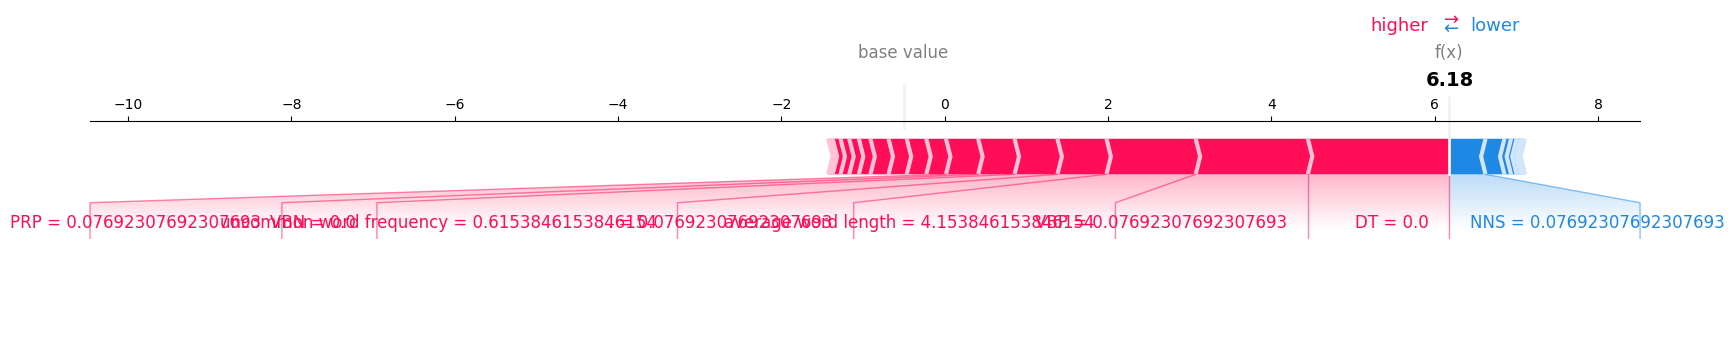

In [22]:
# shap.initjs()
shap.force_plot(
    exp.expected_value[1], test_shap_val[0], test_data.iloc[0], matplotlib=True
)

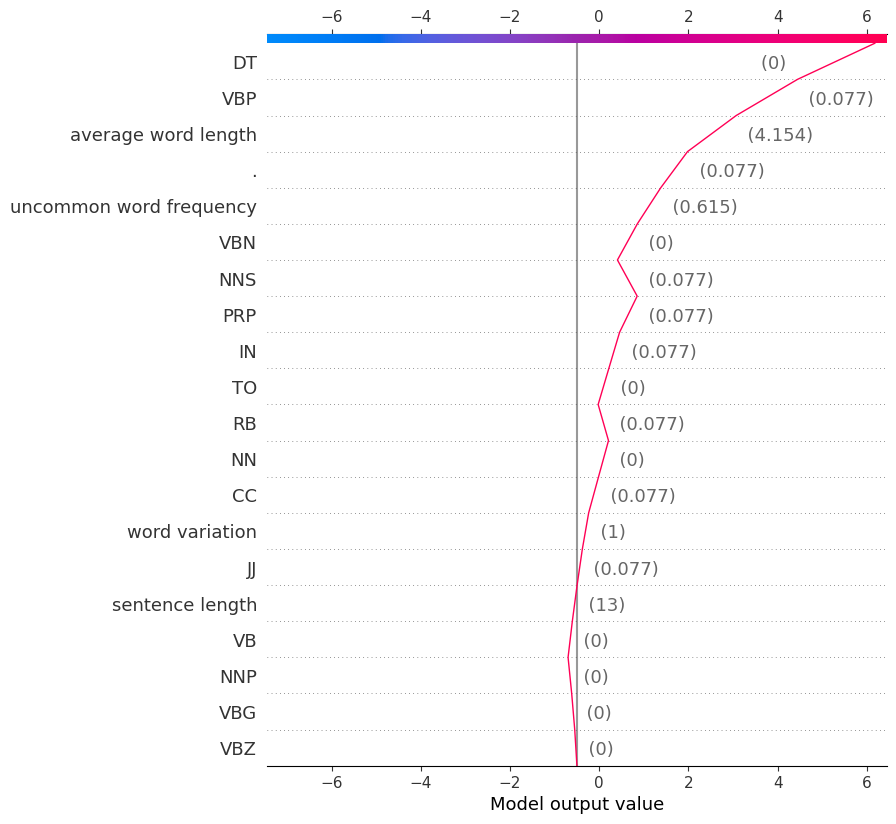

In [23]:
shap.decision_plot(exp.expected_value[1], test_shap_val[0], test_data.iloc[0])

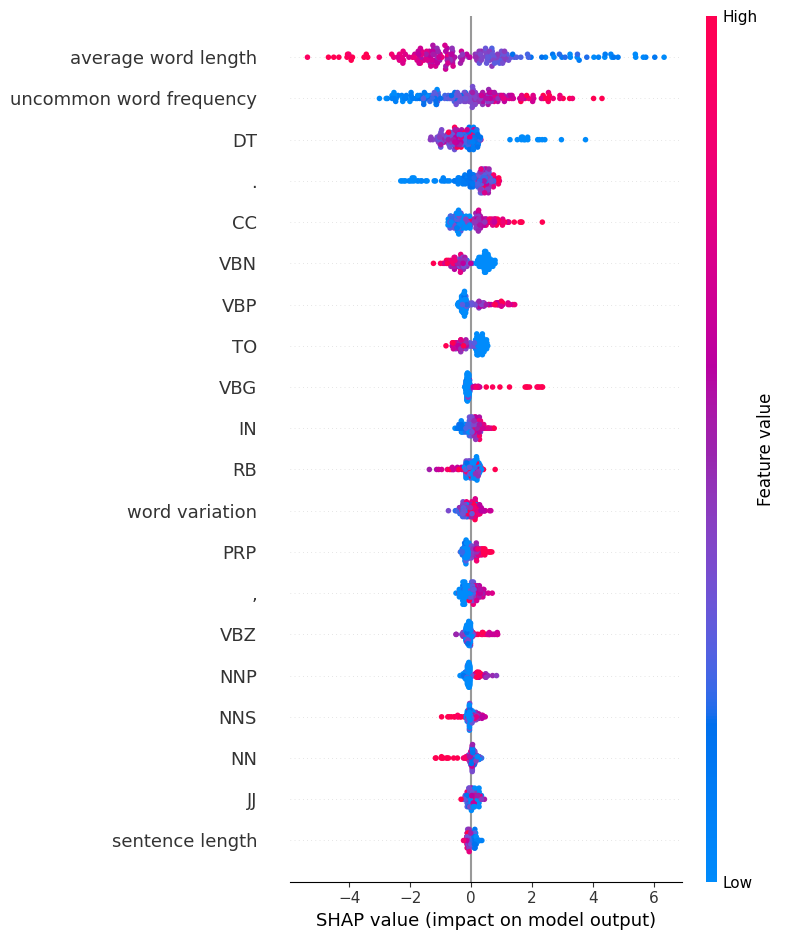

In [24]:
shap.summary_plot(test_shap_val, test_data)

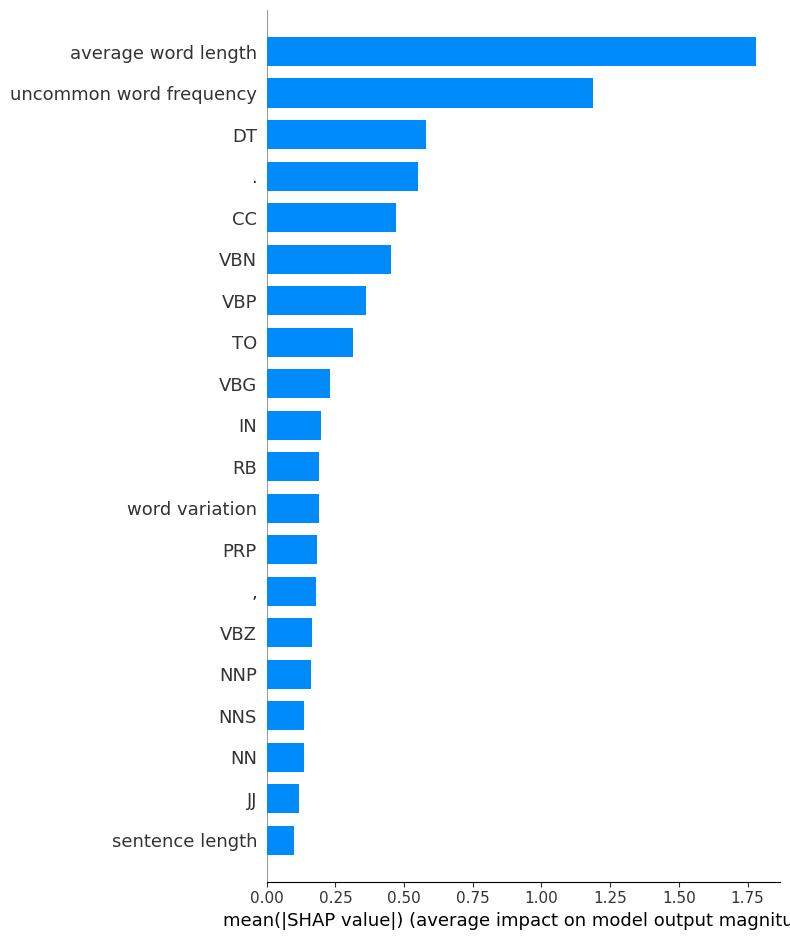

In [25]:
shap.summary_plot(test_shap_val, test_data, plot_type="bar")